In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed = 855835128

In [2]:
# file = pd.read_csv(r'E:\Auckland\2022 Semester 2\COMPSCI 760\Assignment\Presentation 2\ModelDf.csv',sep=',',usecols=[3,4,5,8])
file = pd.read_csv('AgeDataset-V1.csv' )
#file = file.dropna()
data = file[['Gender','Occupation','Country']]
target = file['Manner of death']
print("The feature vectors:\n",data.head())
# print("The predictive vector:\n",target.head())

The feature vectors:
   Gender  Occupation                                            Country
0   Male  Politician  United States of America; Kingdom of Great Bri...
1   Male      Artist                                     United Kingdom
2   Male  Politician                           United States of America
3   Male      Artist    Archduchy of Austria; Archbishopric of Salzburg
4   Male      Artist                 Holy Roman Empire; Austrian Empire


In [3]:
file.dropna(subset=['Manner of death'], inplace=True) #deleting the null row of manner of death
file.dropna(subset=['Occupation'], inplace=True)

## Gender

In [4]:
file['Gender'].value_counts()

Male                          41701
Female                         7769
Transgender Female               21
Transgender Male                 12
Eunuch; Male                      6
Intersex                          2
Transgender Female; Female        1
Eunuch                            1
Name: Gender, dtype: int64

In [5]:
gender_combine = {'Transgender Female' : 'Diverse', 
                  'Transgender Male': 'Diverse', 
                  'Eunuch; Male' : 'Diverse', 
                  'Transgender Female; Female':'Diverse',
                  'Eunuch':'Diverse', 
                  'Intersex': 'Diverse', 
                 }
file['Gender'] = file['Gender'].replace(gender_combine)
file['Gender'].value_counts()

Male       41701
Female      7769
Diverse       43
Name: Gender, dtype: int64

## Manner of death

In [6]:
file['Manner of death'].value_counts()

natural causes                       32934
suicide                               5343
accident                              4831
homicide                              3902
capital punishment                    2430
                                     ...  
cardiac arrest; natural causes           1
accident; shooting                       1
Atentado para uno suizo Zollinger        1
strain                                   1
internment                               1
Name: Manner of death, Length: 188, dtype: int64

(-0.5, 799.5, 499.5, -0.5)

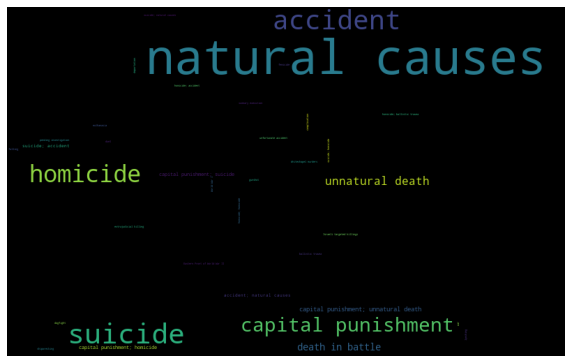

In [7]:
from wordcloud import WordCloud 

MoD = file['Manner of death'].value_counts().to_dict()
freq_death = WordCloud(width =800, height =500).generate_from_frequencies(MoD)
plt.figure(figsize=(10,8))
plt.imshow(freq_death)
plt.axis('off')

Making natural causes, accident, suicide, homicide and capital punishment our target label.

In [8]:
file['Manner of death']=file['Manner of death'].astype(str)
file['Manner of death']=file['Manner of death'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Manner of death'].value_counts()

natural causes                       32935
suicide                               5402
accident                              4867
homicide                              3937
capital punishment                    2593
                                     ...  
strain                                   1
Atentado para uno suizo Zollinger        1
police operation                         1
2015 Saint-Denis raid                    1
shooting attack                          1
Name: Manner of death, Length: 129, dtype: int64

Feature engineering

In [9]:
#only getting the top 5 deaths
deaths = ['natural causes' ,'suicide', 'homicide', 'accident', 'capital punishment']
file = file[file['Manner of death'].isin(deaths)]

<AxesSubplot:title={'center':'Percentage of manner of deaths'}, ylabel='Count'>

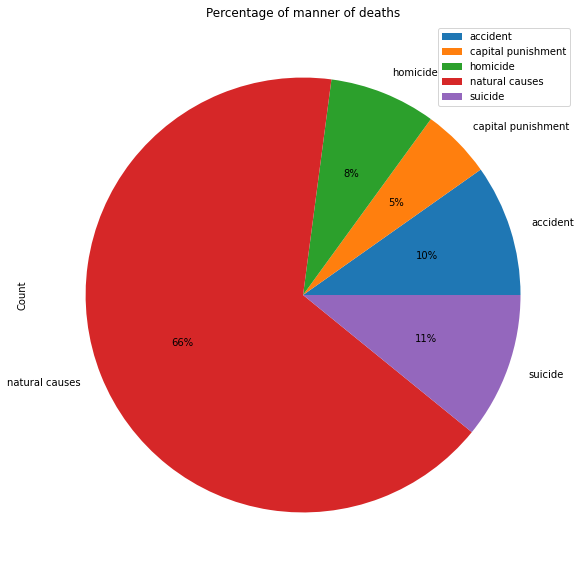

In [10]:
#pie chart for manner of death
#class imbalance
Manner_of_death = file[['Manner of death']].groupby(['Manner of death']).size().reset_index(name='Count').sort_values('Count', ascending = False)
Manner_of_death.groupby(['Manner of death']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%',title='Percentage of manner of deaths', figsize=(15, 10))

<AxesSubplot:xlabel='Age of death', ylabel='Manner of death'>

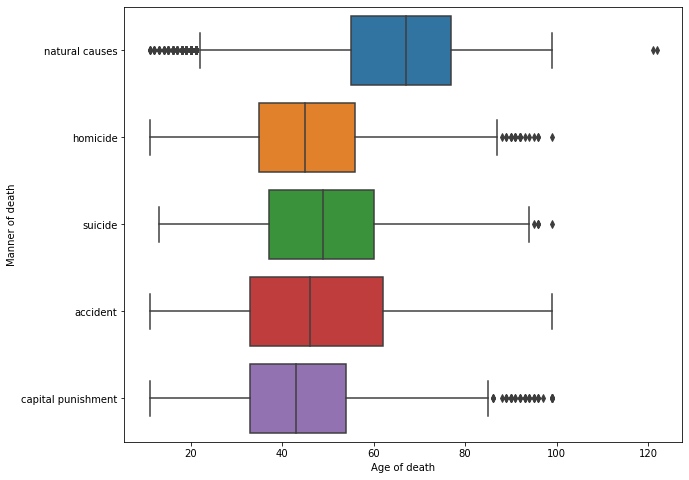

In [11]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file, x='Age of death', y = 'Manner of death')

## Occupation

In [12]:
file['Occupation']=file['Occupation'].astype(str)
file['Occupation']=file['Occupation'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
occu = file['Occupation'].value_counts()
top_occupation = occu.head(10)
top_occupation

Artist                18721
Politician             7999
Athlete                5893
Researcher             2873
Military personnel     2430
Journalist             1051
Businessperson          939
Religious figure        862
Teacher                 430
Engineer                380
Name: Occupation, dtype: int64

In [17]:
file.reset_index(drop=True, inplace=True)

## Hyper parameter tuning

In [19]:
target = file['Manner of death'] #decreased the labels to 5 
data = file[['Gender','Occupation','Country']]

In [20]:
target.nunique()

5

In [21]:
# pre-processing data
data_T = data.T
arr1 = data_T.to_numpy()
temp = np.zeros((3,len(data)))
le1 = preprocessing.LabelEncoder()
for i in range(len(arr1)):
    le1.fit(arr1[i])
    temp[i] = le1.transform(arr1[i])
x_T = pd.DataFrame(temp)
x = x_T.T
x = x.to_numpy()

arr2 = target.to_numpy()
le2 = preprocessing.LabelEncoder()
le2.fit(arr2)
y = le2.transform(arr2)
# The result of pre-processing
print("The feature vectors:\n",x)
print("The predictive vector:\n",y)

The feature vectors:
 [[2.000e+00 6.340e+02 1.428e+03]
 [2.000e+00 4.800e+01 1.296e+03]
 [2.000e+00 6.340e+02 1.351e+03]
 ...
 [1.000e+00 7.080e+02 1.296e+03]
 [2.000e+00 3.890e+02 1.555e+03]
 [2.000e+00 5.170e+02 1.351e+03]]
The predictive vector:
 [3 3 2 ... 3 1 2]


In [22]:
# calculate Gini and Enrtopy
DT = DecisionTreeClassifier(random_state = seed)
score = cross_val_score(DT,x,y,cv=2).mean()
print('Gini: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
score = cross_val_score(DT,x,y,cv=2).mean()
print('Entropy: %.4f'%score)

Gini: 0.6186
Entropy: 0.6191


Entropy is better than Gini in this data set.

The optimal parameters and the highest score:
 [10.          0.64589617]


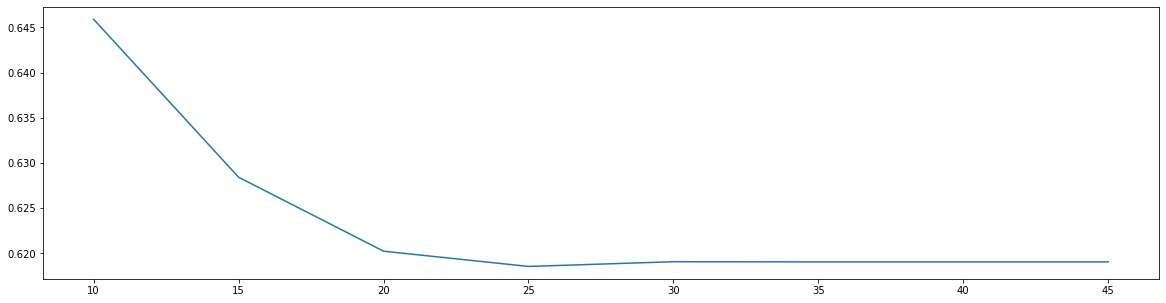

In [23]:
ScoreAll = []
for i in range(10,50,5):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv = 2).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

The optimal parameters and the highest score:
 [3.         0.66344955]


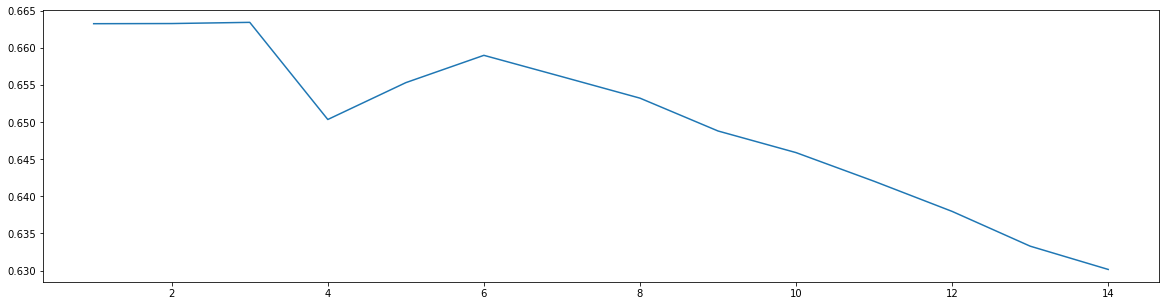

In [24]:
ScoreAll = []
for i in range(1,15):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv = 2).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

The optimal parameters and the highest score:
 [2.        0.6632887]


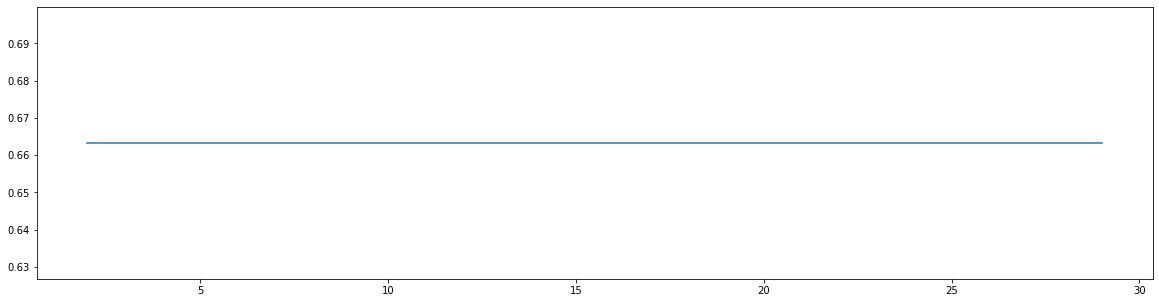

In [25]:
# consider min_samples_split
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 2, min_samples_split = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv=2).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

There is no need to modify the min_samples_split parameter.

The optimal parameters and the highest score:
 [1.        0.6632887]


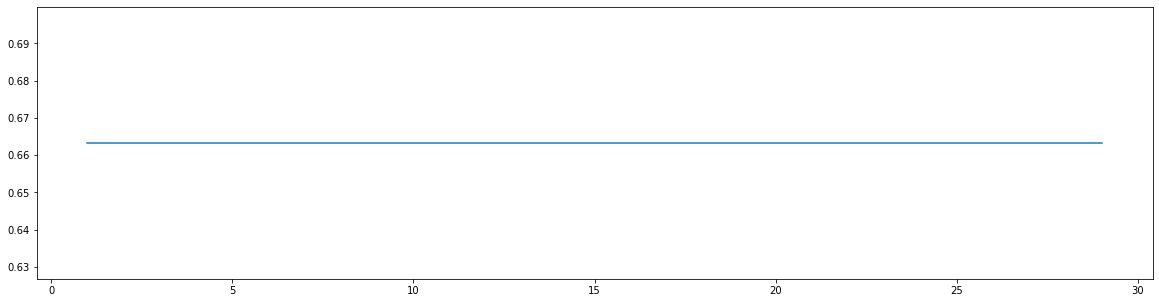

In [26]:
# consider min_samples_leaf
ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i, min_samples_split = 2,max_depth = 2,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv=2).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [27]:
# Entropy,max_depth = 2, min_samples_leaf = 1, min_samples_split = 2
param_grid = {
    'max_depth':np.arange(1,5),
    'min_samples_leaf':np.arange(1,7),
    'min_samples_split':np.arange(1,5)
}
DTC = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
GS = GridSearchCV(DTC,param_grid,cv=2)
GS.fit(x,y)
print(GS.best_params_)
print(GS.best_score_)

/home/ubonto/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubonto/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubonto/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/home/ubonto/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ubonto/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFa

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.6634495516145896
